In [1]:
import math
import statistics
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms as T
from torch.utils.data import Dataset, DataLoader, sampler

In [8]:
# Define the hyperparameters
LEARNING_RATE = 1e-3
BATCH_SIZE = 64
EPOCHS = 1
VAL_SIZE = 10 # In percentage

R_MEAN = 0.4914
G_MEAN = 0.4822
B_MEAN = 0.4465
R_STD = 0.2023
G_STD = 0.1994
B_STD = 0.2010

In [9]:
use_cuda = torch.cuda.is_available()
device = torch.device('cuda' if use_cuda else 'cpu')
print('Using GPU: {}'.format(use_cuda))

Using GPU: False


In [10]:
# Set seed during training for reproducibility
np.random.seed(0)
torch.manual_seed(0)
if use_cuda:
    torch.cuda.manual_seed(0)

In [11]:
# Normalise the dataset
transform = T.Compose([
    T.ToTensor(),
    T.Normalize((R_MEAN, G_MEAN, B_MEAN), (R_STD, G_STD, B_STD))
])

# Augement and normalise the dataset
transform_aug = T.Compose([
    T.RandomCrop(32, padding=4),
    T.RandomHorizontalFlip(p=0.5),
    T.ToTensor(),
    T.Normalize((R_MEAN, G_MEAN, B_MEAN), (R_STD, G_STD, B_STD))
])

In [12]:
training_dataset = datasets.CIFAR10(root='data/', train=True,  transform=transform, download=True)
testing_dataset  = datasets.CIFAR10(root='data/', train=False, transform=transform, download=True)

split_point = math.floor( (100-VAL_SIZE) * len(training_dataset) / 100) 
indices = list(range(len(training_dataset)))

training_dataloader   = torch.utils.data.DataLoader(training_dataset, batch_size=BATCH_SIZE, 
                                                    sampler=torch.utils.data.SubsetRandomSampler(indices[:split_point],
                                                                                                 generator = torch.Generator().manual_seed(0)))
validation_dataloader = torch.utils.data.DataLoader(training_dataset, batch_size=BATCH_SIZE, 
                                                    sampler=torch.utils.data.SubsetRandomSampler(indices[split_point:],
                                                                                                 generator = torch.Generator().manual_seed(0)))
                                                                                                 
testing_dataloader    = torch.utils.data.DataLoader(testing_dataset,  batch_size=BATCH_SIZE, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [13]:
class Mish(nn.Module):
    def __init__(self):
        super(Mish,self).__init__()

    def forward(self, x):
        return x * nn.tanh(nn.softplus(x))

ACTIVATIONS = {
    'relu': nn.ReLU(inplace=True),
    'mish': Mish(),
    'linear': nn.Identity()
}

In [ ]:
class Conv2dBlock(nn.Module):
    def __init__(self, in_C, out_C, k, s, p, activation='relu'):
        super(Conv2dBlock,self).__init__()
        self.forward_pass = nn.Sequential(
            nn.Conv2d(in_channels=in_C, out_channels=out_C, kernel_size=k, stride=s, padding=p, bias=False),
            nn.BatchNorm2d(out_C),
            ACTIVATIONS[activation]
        )

    def forward(self, x):
        return self.forward_pass(x)

In [71]:
class CrossStagePartialBlock(nn.Module):
    def __init__(self, initial_channels, denseBlock_noLayers, c_OUT):
        super(CrossStagePartialBlock,self).__init__()
        self.initial_channels = initial_channels
        self.denseBlock_noLayers = denseBlock_noLayers

        self.dense_block_layers = []
        for k in range(1,1+self.denseBlock_noLayers):
            self.dense_block_layers.append(
                Conv2dBlock(in_C=k*self.initial_channels//2, out_C=self.initial_channels//2,  k=3, s=1, p=1).to(device=device)
            )

        self.transition1 = Conv2dBlock(in_C=(1+self.denseBlock_noLayers)*self.initial_channels//2, 
                                      out_C=(1+self.denseBlock_noLayers)*self.initial_channels//2, k=3, s=1, p=1)

        self.transition2 = Conv2dBlock(in_C=(2+self.denseBlock_noLayers)*self.initial_channels//2, out_C=c_OUT, k=3, s=1, p=1)
        
    def forward(self,x):
        x_0_prime, x_0_second = torch.split(x, (self.initial_channels//2,self.initial_channels//2), dim=1)
        
        dense_block_input = x_0_second
        for k in range(self.denseBlock_noLayers):
            dense_block_input = torch.cat((dense_block_input,self.dense_block_layers[k](dense_block_input)), dim=1)

        x_T = self.transition1(dense_block_input)
        x_U = self.transition2(torch.cat((x_0_prime,x_T), dim=1))

        return x_U

In [72]:
class CSPNet(nn.Module):
    def __init__(self):
        super(CSPNet,self).__init__()
        self.network = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64,  kernel_size=3, stride=1, padding=0),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(in_channels=64, out_channels=128,  kernel_size=3, stride=1, padding=0),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            CrossStagePartialBlock(initial_channels=128, denseBlock_noLayers=3, c_OUT=256),
            nn.MaxPool2d(kernel_size=2, stride=2),

            CrossStagePartialBlock(initial_channels=256, denseBlock_noLayers=3, c_OUT=512),
            nn.AvgPool2d(kernel_size=3),
            
            nn.Flatten(),
            nn.Linear(in_features=512,  out_features=10)
        )

    def forward(self, x):
        return self.network(x)

In [73]:
def loss_function(pred, y):
    return F.cross_entropy(pred, y)

In [74]:
validation_losses = []
def validate(model):
    losses = []
    
    model.eval()
    
    with torch.no_grad():
        for x_valid,y_valid in validation_dataloader:
            x_valid = x_valid.to(device=device, dtype=torch.float32)
            y_valid = y_valid.to(device=device, dtype=torch.long)
            
            pred = model(x_valid)
            
            loss = loss_function(pred,y_valid).item()
            losses.append(loss)
            
    validation_losses.append(statistics.mean(losses))

In [75]:
training_losses = []
def training(model, optimiser):
    for epoch in range(EPOCHS):
        losses = []
        model.train()
        
        for x_train, y_train in training_dataloader:
            x_train = x_train.to(device=device, dtype=torch.float32)
            y_train = y_train.to(device=device, dtype=torch.long)
            
            pred = model(x_train)
            
            loss = loss_function(pred,y_train)
            losses.append(loss.item())
            
            optimiser.zero_grad()
            loss.backward()
            optimiser.step()
            
        mean_loss = statistics.mean(losses)
        training_losses.append(mean_loss)
        print("Epoch {}/{}, training loss = {:.2f}".format(epoch+1, EPOCHS, mean_loss))
        
        validate(model)

Epoch 1/10, training loss = 1.67
Epoch 2/10, training loss = 1.08
Epoch 3/10, training loss = 0.93
Epoch 4/10, training loss = 0.82
Epoch 5/10, training loss = 0.73
Epoch 6/10, training loss = 0.68
Epoch 7/10, training loss = 0.63
Epoch 8/10, training loss = 0.55
Epoch 9/10, training loss = 0.51
Epoch 10/10, training loss = 0.48


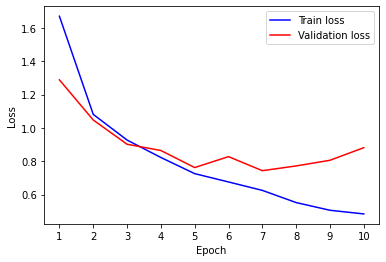

In [76]:
model_CSP = CSPNet()
model_CSP = model_CSP.to(device=device)

optimizer = torch.optim.Adam(model_CSP.parameters(), lr=LEARNING_RATE)

training(model_CSP, optimizer)

plt.figure(0)
plt.plot(list(range(1,EPOCHS+1)), training_losses, 'b')
plt.plot(list(range(1,EPOCHS+1)), validation_losses, 'r')
plt.xticks(list(range(1,EPOCHS+1)))
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train loss','Validation loss'])
plt.show()

In [65]:
def testing(model):
    model.eval()
    
    correct_preds = 0
    total_preds = 0
    
    with torch.no_grad():
        for x_test, y_test in testing_dataloader:
            x_test = x_test.to(device=device, dtype=torch.float32)
            y_test = y_test.to(device=device, dtype=torch.long)
            
            _,pred = model(x_test).max(1)
            
            correct_preds += (pred==y_test).sum()
            total_preds   += pred.size(0)
            
    accuracy = 100 * torch.true_divide(correct_preds,total_preds)
    print('Correct predictions {}/{}, accuracy = {:.2f}%.'.format(correct_preds, total_preds, accuracy))
    
testing(model_CSP)

Correct predictions 7348/10000, accuracy = 73.48%.


In [ ]:
# Save weights if desired
# torch.save(model_CSP.state_dict(), 'CSPNetModel.pt')